# Project: Listening to the Universe
## 1. Gravitational Wave Detection via Spectral Analysis

### 1.1 The Scientific Context: Ripples in Space-Time
Imagine two massive black holes, billions of light-years away, spiraling around each other. As they draw closer, they accelerate until they collide and merge. This cataclysmic event is so powerful that it creates ripples in the fabric of space-time itself, traveling across the universe.

These ripples are known as **Gravitational Waves (GW)**. They originate from astrophysical events technically classified as **Compact Binary Coalescences (CBC)**.

### 1.2 The Signal: Anatomy of a "Chirp"
The waveform produced by these events is known as a **"Chirp"**.
* **Intuitively:** It is a signal where the frequency sweeps upward rapidly.
* **Mathematically:** It is a **non-stationary signal** where the instantaneous frequency increases with time. During the *inspiral phase*, the frequency evolves slowly; as the objects approach the *merger*, both frequency and amplitude increase distinctively.

### 1.3 Computational Challenge: Low Signal-to-Noise Ratio
We use data from **LIGO detectors**, which measure microscopic changes in distance (strain measurements $s(t)$).
The main obstacle is the extremely low **Signal-to-Noise Ratio (SNR)**. The detectors are incredibly sensitive and pick up significant background noise from environmental and instrumental sources (seismic activity, thermal noise, etc.).

The gravitational wave signal is often buried deep within this non-Gaussian noise, making it indistinguishable to the naked eye in the raw time-series data.

### 1.4 Proposed Method: Time-Frequency Representation
To address the low SNR, we transition from 1D signal analysis to **2D pattern recognition**:
1.  **Transformation:** Convert the 1D time-series into a **Spectrogram** (Time-Frequency representation). This isolates the specific "chirp" morphology from the chaotic background noise.
2.  **Detection:** Use a **Convolutional Neural Network (CNN)** to recognize this specific visual shape (the curved track of the chirp) inside the noisy image.

In [22]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from nnAudio.Spectrogram import CQT1992v2

# --- CONFIGURATION ---
# Define the path to the raw dataset
BASE_DATA_PATH = "../data/raw"
LABELS_PATH = os.path.join(BASE_DATA_PATH, "subset_labels.csv")

# Automatically locate the directory containing the .npy files
TRAIN_DIR = None
for root, dirs, files in os.walk(BASE_DATA_PATH):
    for file in files:
        if file.endswith(".npy"):
            TRAIN_DIR = root
            break
    if TRAIN_DIR:
        break

print(f"Labels file path: {LABELS_PATH}")
print(f"Training data directory: {TRAIN_DIR}")

Labels file path: ../data/raw/subset_labels.csv
Training data directory: ../data/raw/g2net_subset


## 2. Dataset and Target Definition
The dataset consists of time-series segments sampled at 2048 Hz.
* **Target 0 (Noise):** Background noise only.
* **Target 1 (Signal):** Simulated GW signal injected into background noise.

We load a confirmed positive sample (`target=1`) to analyze the signal properties in the time domain versus the frequency domain.

In [23]:
# Load the dataset labels
df_labels = pd.read_csv(LABELS_PATH)

# --- SAMPLE SELECTION ---
# We focus on samples with target=1 (Confirmed Gravitational Wave)
# to analyze the spectral properties of the signal.

SEARCH_SEED = 42 

# Filter for positive samples and select one based on the seed
positive_samples = df_labels[df_labels['target'] == 1]
sample = positive_samples.sample(1, random_state=SEARCH_SEED).iloc[0]

sample_id = sample['id']
sample_path = os.path.join(TRAIN_DIR, f"{sample_id}.npy")

print(f"Selected Sample ID: {sample_id}")
print(f"Target Label: {sample['target']}")

Selected Sample ID: 0e6447544d
Target Label: 1


## 3. Signal Preprocessing: Time-Frequency Analysis

To detect a transient signal like a chirp, analyzing the raw time domain $s(t)$ is insufficient because the spectral content changes over time. We need to map the signal into the Time-Frequency domain.

### 3.1 The Limitation of Fourier Transform (FT)
The standard Fourier Transform decomposes a signal into its constituent sinusoids:
$$X(f) = \int_{-\infty}^{\infty} x(t) e^{-j 2\pi f t} dt$$
While this provides perfect frequency resolution, it loses all time information. We know *which* frequencies exist, but not *when* they occur. This is unsuitable for non-stationary signals like GW chirps.

### 3.2 Short-Time Fourier Transform (STFT)
To recover time information, the standard approach is the STFT, which applies a sliding window function $w(t)$:
$$\text{STFT}(t, f) = \int_{-\infty}^{\infty} x(\tau) w(\tau - t) e^{-j 2\pi f \tau} d\tau$$
However, the STFT imposes a fixed resolution grid due to the Uncertainty Principle (Gabor Limit): $\Delta t \Delta f \ge \frac{1}{4\pi}$.
* A wide window gives good frequency resolution but poor time resolution.
* A narrow window gives good time resolution but poor frequency resolution.

Since STFT uses a **linear frequency grid** ($f_k = k \Delta f$), it cannot optimally resolve a GW chirp, which spans from low frequencies (requiring high spectral resolution) to high frequencies (requiring high temporal resolution) very rapidly.

### 3.3 The Solution: Constant Q-Transform (CQT)
The Constant Q-Transform solves the resolution trade-off by using a **logarithmic frequency grid**.
Instead of a constant $\Delta f$, the CQT maintains a constant ratio $Q$ between the center frequency $f_k$ and the bandwidth $\Delta f_k$:
$$Q = \frac{f_k}{\Delta f_k} = \text{constant}$$

The center frequencies are geometrically spaced:
$$f_k = f_{min} \cdot 2^{\frac{k}{b}}$$
where $b$ represents the number of bins per octave.

**Why CQT for Gravitational Waves?**
This transform adapts the window size to the frequency:
1.  **Low Frequencies:** Long windows $\rightarrow$ High Frequency Resolution (crucial for the early inspiral phase).
2.  **High Frequencies:** Short windows $\rightarrow$ High Time Resolution (crucial for the merger event).

This results in a much sharper spectral image of the chirp compared to standard STFT, significantly improving the feature extraction capabilities of the CNN.

In [24]:
# 1. Load the raw time-series signal
raw_signal = np.load(sample_path)

# 2. Channel Selection
# The dataset contains 3 channels (LIGO Hanford, LIGO Livingston, Virgo).
# We visualize the first channel for demonstration purposes.
signal_channel = raw_signal[0]

# 3. Standardization (Normalization)
# Normalizing the signal amplitude is crucial for Neural Network stability.
signal_tensor = torch.from_numpy(signal_channel).float()
signal_tensor = signal_tensor / torch.max(torch.abs(signal_tensor))

# 4. Constant Q-Transform (CQT)
# We utilize CQT instead of standard STFT to obtain a logarithmic frequency resolution,
# which effectively captures the 'chirp' morphology (rising frequency) of GW signals.
# fmin=20Hz and fmax=500Hz are chosen based on LIGO detector sensitivity.
cqt_transform = CQT1992v2(sr=2048, fmin=20, fmax=500, hop_length=64)

# Apply transform (Add batch dimension: [1, time_steps] -> [1, freq, time])
spectrogram = cqt_transform(signal_tensor.unsqueeze(0))

print(f"Spectrogram shape: {spectrogram.shape}")

CQT kernels created, time used = 0.0660 seconds
Spectrogram shape: torch.Size([1, 56, 65])


/Users/stefano/final-project-FDS/.venv/lib/python3.13/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


## 4. Visual Analysis and Interpretation

The plots below compare the raw Time Domain representation with the CQT Time-Frequency representation.

* **Left (Time Domain):** The signal is completely dominated by non-Gaussian noise. In this 1D representation, the gravitational wave is mathematically indistinguishable from background fluctuations without advanced filtering.
* **Right (CQT Spectrogram):** The logarithmic frequency mapping transforms the temporal signal into a spatial map.
    * **Observation:** In high-energy events (high SNR), the **"Chirp"** appears as a faint curvilinear feature rising in frequency.
    * **The Challenge:** In many samples, the signal remains visually buried in noise to the human eye. However, the CQT concentrates the signal energy into a specific geometric path.

**Conclusion:**
While the signal may remain faint to the naked eye, the spectrogram converts the detection problem into a **pattern recognition problem**. This allows the Convolutional Neural Network (CNN) to detect statistical correlations along the "chirp" track that are invisible in the raw time series.

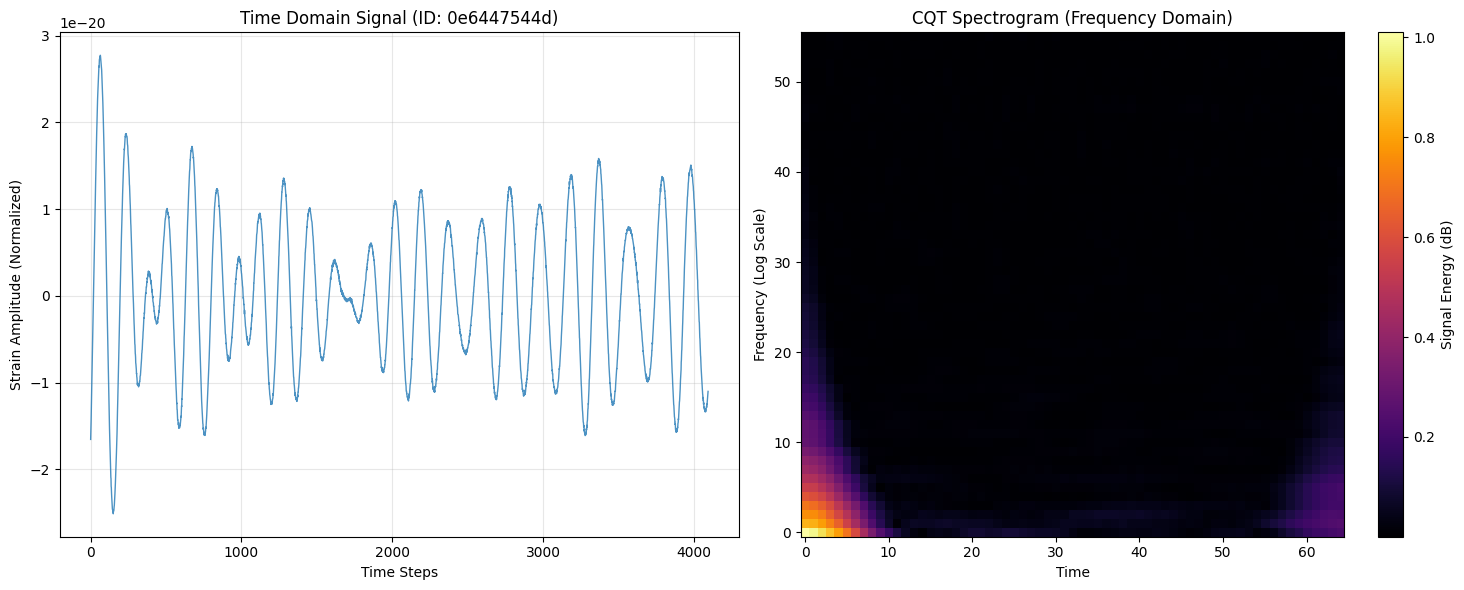

In [25]:
plt.figure(figsize=(15, 6))

# Plot 1: Time Domain Representation
plt.subplot(1, 2, 1)
plt.plot(signal_channel, alpha=0.8, linewidth=1.0, color='#1f77b4')
plt.title(f"Time Domain Signal (ID: {sample_id})")
plt.xlabel("Time Steps")
plt.ylabel("Strain Amplitude (Normalized)")
plt.grid(True, alpha=0.3)

# Plot 2: Time-Frequency Representation (Spectrogram)
plt.subplot(1, 2, 2)
# We visualize the spectrogram magnitude
plt.imshow(spectrogram.squeeze(), aspect='auto', origin='lower', cmap='inferno')
plt.title("CQT Spectrogram (Frequency Domain)")
plt.xlabel("Time")
plt.ylabel("Frequency (Log Scale)")
plt.colorbar(label='Signal Energy (dB)')

plt.tight_layout()
plt.show()